# Capstone: Airbnb Price Listing Prediction

_Authors: Evonne Tham_


<div class="alert alert-block alert-danger">


<b>Checkin 3</b>

The actual deliverable for this section is fairly small. You are expected to submit, via this Google form, a progress report detailing where you are with your Capstone. The format and content is up to you but, at a minimum, we expect the following:


- Do you have data fully in hand and if not, what blockers are you facing?
- Have you done a full EDA on all of your data?
- Have you begun the modeling process? How accurate are your predictions so far?
- What blockers are you facing, including processing power, data acquisition, modeling difficulties, data cleaning, etc.? How can we help you overcome those challenges?
- Have you changed topics since your lightning talk? Since you submitted your Problem Statement and EDA? If so, do you have the necessary data in hand (and the requisite EDA completed) to continue moving forward?
- What is your timeline for the next week and a half? What do you have to get done versus what would you like to get done?
- What topics do you want to discuss during your 1:1?
- We will use your progress report as a leaping off point for a deep 1:1 with a member of the instructional staff. The best use of your time is to really flesh out this document so that your remaining time here can be most productive.

</div>

<div class="alert alert-block alert-warning">


<b>Checkin 2: Think about the following as you perform your initial EDA.</b>

- Examine the distributions of your data, numerically and/or visually.
- Identify outliers.
- ~~Identify missing data and look for patterns of missing data.~~
- Describe how your EDA will inform your modeling decisions and process.

</div>

## <span style='background:yellow'> 1. Import Necessary Libraries & Load Data </span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   

# RdYlGn

sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
country = 'japan/'
path = '../datasets/'

calendar = pd.read_csv(path + country + 'calendar.csv')
listing = pd.read_csv(path + country + 'listings.csv')
neighbourhood = pd.read_csv(path + country + 'neighbourhoods.csv')
reviews = pd.read_csv(path + country + 'reviews.csv')

In [3]:
# # show all rows and columns
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

## <span style='background:yellow'> 2. Initial Exploratory Analysis </span>
Evaluate the current state of the data

##### Defining Functions

In [4]:
def eda(dataframe):
    
    """Runs basic EDA on dataframe."""
    
    print("DF shape: ", dataframe.shape)
    print("")
    print("DF types:\n", dataframe.dtypes)
    print("***********************************************************************************")
    print("")
    print("DF describe: \n", dataframe.describe())
    print("***********************************************************************************")
    print("")
    print("DF describe: \n", dataframe.describe(exclude=np.number).T)
    print("***********************************************************************************")
    print("")
    print("Missing values: \n", 
          (dataframe.isnull().sum())[dataframe.isnull().sum()>0].sort_values(ascending=False))
    print("***********************************************************************************")
    print("")
    print("duplicate values: ", dataframe.duplicated().sum())
    print("***********************************************************************************")
    print("")
    #check if column is unique
    for i in dataframe.columns:
        print('{} is unique: {}'.format(i, dataframe[i].is_unique))
    print("***********************************************************************************")
    print("***********************************************************************************")
    print("")

### <span style='background:yellow'> 2.1. Calendar Dataset</span>

In [5]:
eda(calendar)

DF shape:  (5478916, 7)

DF types:
 listing_id          int64
date               object
available          object
price              object
adjusted_price     object
minimum_nights    float64
maximum_nights    float64
dtype: object
***********************************************************************************

DF describe: 
          listing_id  minimum_nights  maximum_nights
count  5.478916e+06    5.478304e+06    5.478304e+06
mean   3.171776e+07    3.755993e+00    7.605496e+02
std    9.436219e+06    9.781669e+00    4.582027e+02
min    3.530300e+04    1.000000e+00    1.000000e+00
25%    2.651004e+07    1.000000e+00    3.650000e+02
50%    3.344028e+07    1.000000e+00    1.125000e+03
75%    3.967955e+07    2.000000e+00    1.125000e+03
max    4.357856e+07    3.650000e+02    1.163000e+03
***********************************************************************************

DF describe: 
                   count unique         top     freq
date            5478916    366  2020-10-19    15

In [6]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3395898,2020-05-30,f,"$5,000.00","$5,000.00",28.0,1125.0
1,5262640,2020-05-30,t,"$4,515.00","$4,515.00",3.0,1125.0
2,5262640,2020-05-31,t,"$4,515.00","$4,515.00",3.0,1125.0
3,5262640,2020-06-01,t,"$4,515.00","$4,515.00",3.0,1125.0
4,5262640,2020-06-02,t,"$4,515.00","$4,515.00",3.0,1125.0


In [7]:
print(calendar['date'].min())
print(calendar['date'].max())

2020-05-30
2021-05-30


<div class="alert alert-block alert-success">

<b> Calendar Dataset Observations: </b>
- calendar ranged from 2020-05-30 to 21-05-30
- most likely t and f represents true and false
- columns that might be useful 
    - listing_id (to combine with other datasets)
    - date
    - available
    - price

<b> To-Dos: </b>
- convert date object to datetime
- remove $, from price column
- get dummy for available column
- replace t and f value to 1s and 0s
- fill Null values fro minimum and maximum nights
</div>

### <span style='background:yellow'> 2.2. Listing Dataset </span>

In [8]:
eda(listing)

DF shape:  (15009, 106)

DF types:
 id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 106, dtype: object
***********************************************************************************

DF describe: 
                  id     scrape_id  thumbnail_url  medium_url  xl_picture_url  \
count  1.500900e+04  1.500900e+04            0.0         0.0             0.0   
mean   3.171782e+07  2.020053e+13            NaN         NaN 

duplicate values:  0
***********************************************************************************

id is unique: True
listing_url is unique: True
scrape_id is unique: False
last_scraped is unique: False
name is unique: False
summary is unique: False
space is unique: False
description is unique: False
experiences_offered is unique: False
neighborhood_overview is unique: False
notes is unique: False
transit is unique: False
access is unique: False
interaction is unique: False
house_rules is unique: False
thumbnail_url is unique: False
medium_url is unique: False
picture_url is unique: False
xl_picture_url is unique: False
host_id is unique: False
host_url is unique: False
host_name is unique: False
host_since is unique: False
host_location is unique: False
host_about is unique: False
host_response_time is unique: False
host_response_rate is unique: False
host_acceptance_rate is unique: False
host_is_superhost is unique: False
host_thumbnail_url is unique: False
host_picture_url is

In [9]:
listing.head().T

,0,1,2,3,4
id,35303,197677,289597,370759,700253
listing_url,https://www.airbnb.com/rooms/35303,https://www.airbnb.com/rooms/197677,https://www.airbnb.com/rooms/289597,https://www.airbnb.com/rooms/370759,https://www.airbnb.com/rooms/700253
scrape_id,20200530034812,20200530034812,20200530034812,20200530034812,20200530034812
last_scraped,2020-05-30,2020-05-30,2020-05-30,2020-05-30,2020-05-30
name,"La Casa Gaienmae C Harajuku, Omotesando is nearby",Oshiage Holiday Apartment,Private apt in central Tokyo #203,"Cozy flat #203, local area YET 10 mins to shib...",Private apt in central Tokyo #201
...,...,...,...,...,...
calculated_host_listings_count,3,1,2,3,2
calculated_host_listings_count_entire_homes,2,1,2,3,2
calculated_host_listings_count_private_rooms,1,0,0,0,0
calculated_host_listings_count_shared_rooms,0,0,0,0,0


<div class="alert alert-block alert-success">

<b> Observations: </b>
- Dataset consist of 15009 listings 
- has over 100 features

<b> To-Dos: </b>
- To dropping columns (entirely made up of NaNs): 
    - neighbourhood_group_cleansed,
    - medium_url, 
    - thumbnail_url, 
    - xl_picture_url, 
    - jurisdiction_names
    - experiences_offered
- consider dropping columns(consist of only about 100 data):
    - square_feet 
    - monthly_price
    - weekly_price
- consider dropping columns that are text focused
- drop rows with mostly null value
- replace t and f value to 1s and 0s
- one hot coding for categorical variables, for example
    - cancellation policy ('strict_14_with_grace_period', 'moderate', 'flexible', 'strict',
       'super_strict_60', 'super_strict_30')
    - property_type
    - room_type
- clean columns with $ 
- review scores - imputate with median
</div>

### <span style='background:yellow'> 2.3. Neighbourhood Dataset </span>

In [10]:
eda(neighbourhood)

DF shape:  (62, 2)

DF types:
 neighbourhood_group    float64
neighbourhood           object
dtype: object
***********************************************************************************

DF describe: 
        neighbourhood_group
count                  0.0
mean                   NaN
std                    NaN
min                    NaN
25%                    NaN
50%                    NaN
75%                    NaN
max                    NaN
***********************************************************************************

DF describe: 
               count unique        top freq
neighbourhood    62     62  Fussa Shi    1
***********************************************************************************

Missing values: 
 neighbourhood_group    62
dtype: int64
***********************************************************************************

duplicate values:  0
***********************************************************************************

neighbourhood_group is unique: 

In [11]:
neighbourhood.head()

,neighbourhood_group,neighbourhood
0,NaN,Adachi Ku
1,NaN,Akiruno Shi
2,NaN,Akishima Shi
3,NaN,Aogashima Mura
4,NaN,Arakawa Ku


<div class="alert alert-block alert-success">

<b> Neighbourhood Dataset Observations: </b>
- fairly simple dataset 
- total 62 neighbourhood
- might not need this dataset for analysis

<b> To-Dos: </b>
- to drop neighbourhood_group column (fully NaNs)
</div>

### <span style='background:yellow'> 2.4. Reviews Dataset </span>

In [12]:
eda(reviews)

DF shape:  (398181, 6)

DF types:
 listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object
***********************************************************************************

DF describe: 
          listing_id            id   reviewer_id
count  3.981810e+05  3.981810e+05  3.981810e+05
mean   2.205042e+07  3.896922e+08  1.186371e+08
std    1.015416e+07  1.666141e+08  8.974241e+07
min    3.530300e+04  5.542850e+05  4.840000e+02
25%    1.381362e+07  2.535705e+08  4.174010e+07
50%    2.243749e+07  4.253372e+08  1.011082e+08
75%    3.009148e+07  5.406577e+08  1.822047e+08
max    4.343082e+07  6.267388e+08  3.479244e+08
***********************************************************************************

DF describe: 
                 count  unique         top  freq
date           398181    2542  2019-11-03  1162
reviewer_name  398179  103821     Michael  1785
comments       397901  383139  

In [13]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,35303,810980,2011-12-28,1502908,Firuz,Miyuki's has been a great host. Helpful and ve...
1,35303,2467161,2012-10-01,350719,Jordan,Nice apartment in one of the best areas of Tok...
2,35303,3572628,2013-02-18,4917704,Aymeric,A very nice host and place. The location is in...
3,35303,3952097,2013-03-30,3243253,Blandine,Miyuki is the most smily face I met when I lan...
4,35303,4377509,2013-05-01,1536097,Kayleigh,The location's wonderful. It's close to Haraju...


In [14]:
print(reviews['date'].min())
print(reviews['date'].max())

2011-09-21
2020-05-30


<div class="alert alert-block alert-success">

<b> Reviews Dataset Observations: </b>
- there are 398181 reviews
- dated from 2011-09-21 to 2020-05-30
- 280 missing comments

<b> To dos: </b>

- convert date object to datetime
- clean comments

</div>

## <span style='background:yellow'> 3. Data Cleaning </span>

##### Defining Functions

In [15]:
def mass_cleaning(df):
    
    """Clean date and replace ts and fs"""
    
    # Convert date column
    if 'date' in df.columns: 
        df['date'] = pd.to_datetime(df['date'])
#         df['year'] = df.date.dt.year
#         df['month'] = df.date.dt.month
    
    #Columns with Ts and Fs
    df.replace({'f': 0, 't': 1}, inplace=True)
    
    # Clean Currency
    df = df.applymap(lambda x: int(x.replace('$','').replace(',','').replace('.00','')) 
                     if (type(x) == str) and (x[0]=='$') else x )
    
    return df

In [16]:
def impute_median(df, column):
    
    """ replace NaN values with median"""
    
    df[column].fillna((df[column].median()), inplace=True)

### <span style='background:yellow'> 3.1. Calendar </span>

In [17]:
calendar = mass_cleaning(calendar)
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3395898,2020-05-30,0,5000,5000,28.0,1125.0
1,5262640,2020-05-30,1,4515,4515,3.0,1125.0
2,5262640,2020-05-31,1,4515,4515,3.0,1125.0
3,5262640,2020-06-01,1,4515,4515,3.0,1125.0
4,5262640,2020-06-02,1,4515,4515,3.0,1125.0


In [18]:
# Imputate missing values in minimum maximum nights with 1s, 0s 
calendar['minimum_nights'].fillna(0, inplace=True)
calendar['maximum_nights'].fillna(0, inplace=True)

# Replace continuous to discrete
calendar['minimum_nights'] = calendar['minimum_nights'].astype(int)
calendar['maximum_nights'] = calendar['maximum_nights'].astype(int)

#Check for nulls
calendar.isnull().sum()

listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    0
maximum_nights    0
dtype: int64

<div class="alert alert-block alert-warning">
<b>Note to self:</b>
^ Might consider dropping `minimum_nights` and  `maximum_nights`
</div>

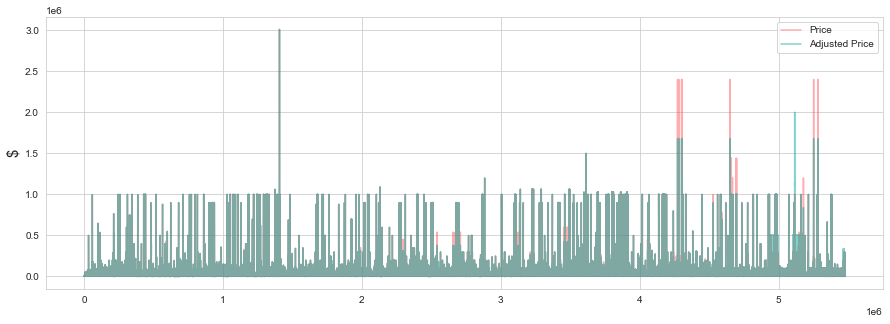

In [19]:
plt.figure(figsize=(15,5))
calendar['price'].plot.line(alpha=0.5, color = '#FF5A5F')
calendar['adjusted_price'].plot.line(alpha=0.5, color = '#00A699')
plt.ylabel('$', fontsize = 15)
plt.legend(['Price', 'Adjusted Price']);

<div class="alert alert-block alert-warning">

<b>Note to self:</b>
Doesnt seem to have much difference in majority of the lising, can consider dropping `adjusted_price`?


</div>

##### Dropping Columns

<div class="alert alert-block alert-warning">

<b>Note to self:</b>
To remove lines in line18, if dropping cols

</div>

In [20]:
# cols_to_drop = ['adjusted_price', 'minimum_nights', 'maximum_nights']

# calendar = calendar.drop(cols_to_drop, axis=1)
# calendar.shape

##### Save DataFrame

In [21]:
calendar.to_csv("../datasets/calendar_cleaned.csv")

### <span style='background:yellow'> 3.2. Listing </span>

In [22]:
listing = mass_cleaning(listing)

##### Isolate and inspect categorical and numerical variable

<div class="alert alert-block alert-success">
As the the number of features is fairly large, I will be splitting them up by categorical and numerical.
</div>

In [23]:
categorical_df = listing.select_dtypes(include=['object', 'bool'])
categorical_cols = listing.select_dtypes(include=['object', 'bool']).columns.values

In [24]:
categorical_df.head(2).T

,0,1
listing_url,https://www.airbnb.com/rooms/35303,https://www.airbnb.com/rooms/197677
last_scraped,2020-05-30,2020-05-30
name,"La Casa Gaienmae C Harajuku, Omotesando is nearby",Oshiage Holiday Apartment
summary,This shared flat is locating at very close to ...,NaN
space,This apartment is 3 bedroom flat shared with t...,"We are happy to welcome you to our apartment, ..."
description,This shared flat is locating at very close to ...,"We are happy to welcome you to our apartment, ..."
experiences_offered,none,none
neighborhood_overview,10 min walking to Harajuku ~ Urahara ~ Omotesa...,NaN
notes,Current tenants are living in this flat over 2...,NaN
transit,"5min to subway, 10min to JR stations, you can ...",NaN


In [25]:
numerical_df = listing.select_dtypes(include=['int', 'float'])
numerical_cols = listing.select_dtypes(include=['int', 'float']).columns.values

In [26]:
numerical_df.head(2).T

,0,1
id,3.530300e+04,1.976770e+05
scrape_id,2.020053e+13,2.020053e+13
thumbnail_url,NaN,NaN
medium_url,NaN,NaN
xl_picture_url,NaN,NaN
host_id,1.519770e+05,9.640810e+05
host_is_superhost,0.000000e+00,1.000000e+00
host_listings_count,3.000000e+00,1.000000e+00
host_total_listings_count,3.000000e+00,1.000000e+00
host_has_profile_pic,1.000000e+00,1.000000e+00


### 3.2.1. Dropping  and Convert Columns

<div class="alert alert-block alert-success">
    
<b>Explanation:</b>

From the data shown above (categorical/numerical), I will be dropping text columns for now and columns that might not be useful for predicting price. 
</div>

In [27]:
cols_to_drop = ['listing_url', 'last_scraped', 'name', 'summary','space', 
                'description', 'neighborhood_overview', 'notes', 'transit', 'access', 
                'interaction', 'house_rules', 'picture_url', 'host_url','host_name', 
                'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url','host_neighbourhood', 
                'host_verifications', 'calendar_last_scraped', 'license', 'scrape_id','thumbnail_url',
                'medium_url', 'xl_picture_url'
               ]

listing = listing.drop(cols_to_drop, axis=1)
listing.shape

(15009, 79)

In [28]:
# Convert rest of the date object column to datetime columns
listing['host_since'] = pd.to_datetime(listing['host_since'])
listing['first_review'] = pd.to_datetime(listing['first_review'])
listing['last_review'] = pd.to_datetime(listing['last_review'])

In [29]:
# Check for columns that has more than 10000 Null values
listing.isnull().sum()[listing.isnull().sum()>10000].sort_values(ascending=False)

jurisdiction_names              15009
neighbourhood_group_cleansed    15009
square_feet                     14998
monthly_price                   14835
weekly_price                    14824
dtype: int64

In [30]:
# Drop columns consist a majority of NaNs 
# reviews_per_month and number_of_reviews_ltm columns will be dropped as well as there is number_of_reviews 
# experiences_offered are all 'none' values as well
listing.drop(['jurisdiction_names','neighbourhood_group_cleansed','square_feet',
              'monthly_price','weekly_price', 'reviews_per_month','number_of_reviews_ltm', 
              'experiences_offered'], 
             axis=1, inplace=True)

In [31]:
listing.shape

(15009, 71)

### 3.2.2  Imputation of Missing Values

In [32]:
listing.isnull().sum()[listing.isnull().sum()>1000].sort_values(ascending=False)

review_scores_value            2667
review_scores_location         2667
review_scores_communication    2667
review_scores_checkin          2667
review_scores_cleanliness      2667
review_scores_accuracy         2667
review_scores_rating           2667
last_review                    2643
first_review                   2643
host_response_rate             1851
host_response_time             1851
neighbourhood                  1482
security_deposit               1262
dtype: int64

<div class="alert alert-block alert-success">
    
<b>Assumption:</b>

Missing data from (cols that start with name): 

- review_scores 
- host_response
- last_review 
- first_review
- host_acceptance_rate

Might be an indication of properties that are new listing that has not been contacted yet. Hence they do not have any response time and rate, and/or ratings . Hence, null values for these features will be filled with `unknown`

</div>

##### a. Review Scores

In [33]:
# Imputate null values with 'Unknown' for column that
# starts with review_scores_ and ends with _review
for col in listing.columns:
    if (col in listing.columns[listing.columns.str.startswith('review_')]) | (col in listing.columns[listing.columns.str.endswith('_review')]):
        listing[col].fillna('unknown', inplace = True)

In [34]:
listing.isnull().sum()[listing.isnull().sum()>0].sort_values(ascending=False)

host_response_time           1851
host_response_rate           1851
neighbourhood                1482
security_deposit             1262
zipcode                       968
cleaning_fee                  702
host_acceptance_rate          435
state                         218
city                           51
beds                           42
bedrooms                       23
host_identity_verified          7
host_has_profile_pic            7
host_total_listings_count       7
host_listings_count             7
host_is_superhost               7
host_since                      7
bathrooms                       4
market                          1
dtype: int64

##### b. Host response time , rate and acceptance rate

In [35]:
# Host response time
listing.host_response_time.value_counts()

within an hour        11028
within a few hours     1195
within a day            783
a few days or more      152
Name: host_response_time, dtype: int64

In [36]:
listing.host_response_time.fillna("unknown", inplace=True)
listing.host_response_time.value_counts(normalize=True)

within an hour        0.734759
unknown               0.123326
within a few hours    0.079619
within a day          0.052169
a few days or more    0.010127
Name: host_response_time, dtype: float64

In [37]:
# Host response rate
listing.host_response_rate.value_counts()

100%    10905
90%       762
80%       164
94%       133
0%        127
50%       118
67%       106
88%       100
70%        83
92%        72
75%        71
95%        71
71%        66
86%        63
83%        47
98%        45
89%        38
96%        25
91%        21
99%        21
85%        20
81%        14
40%        14
97%        13
63%        11
60%        10
73%        10
93%         7
33%         7
64%         5
78%         5
20%         3
25%         1
Name: host_response_rate, dtype: int64

In [38]:
# Remove unneccessary characters
listing.host_response_rate = listing.host_response_rate.str[:-1].astype('float64')

# Impute missing values with unknown
listing.host_response_rate.fillna('unknown', inplace=True)

In [39]:
listing.host_acceptance_rate.value_counts().head()

100%    9822
99%     1350
98%      768
97%      435
96%      278
Name: host_acceptance_rate, dtype: int64

In [40]:
# Host acceptance rate
# Remove unneccessary characters
listing.host_acceptance_rate = listing.host_acceptance_rate.str[:-1].astype('float64')

# Impute missing values with unknown
listing.host_acceptance_rate.fillna('unknown', inplace=True)

# Check
listing.isnull().sum()[listing.isnull().sum()>0].sort_values(ascending=False)

neighbourhood                1482
security_deposit             1262
zipcode                       968
cleaning_fee                  702
state                         218
city                           51
beds                           42
bedrooms                       23
host_identity_verified          7
host_has_profile_pic            7
host_total_listings_count       7
host_listings_count             7
host_is_superhost               7
host_since                      7
bathrooms                       4
market                          1
dtype: int64

In [41]:
listing.isnull().sum()[listing.isnull().sum()>0].sort_values(ascending=False)

neighbourhood                1482
security_deposit             1262
zipcode                       968
cleaning_fee                  702
state                         218
city                           51
beds                           42
bedrooms                       23
host_identity_verified          7
host_has_profile_pic            7
host_total_listings_count       7
host_listings_count             7
host_is_superhost               7
host_since                      7
bathrooms                       4
market                          1
dtype: int64

##### c. Address Related

<div class="alert alert-block alert-success">
    
<b>Observation:</b>

Looking at the categorical_df dataset. There are a couple of columns that are address related 
- street
- neighbourhood
- neighbourhood_cleansed --> to keep (Since the column is kept, Neighbourhood Dataset will not be required
- city
- state
- zipcode
- market
- smart_location
- country_code --> to keep
- country

From numerical_df, to safe in a new dataframe for later use
- longitute 
- latitude

</div>

In [42]:
# To Check and Compare Address Related Columns

# print(listing.street.value_counts())
# print(listing.street.nunique())
# print(listing.neighbourhood_cleansed.value_counts())
print(listing.neighbourhood_cleansed.nunique())
# print(listing.city.value_counts())
# print(listing.city.nunique())
# print(listing.state.value_counts())
# print(listing.state.nunique())
# print(listing.market.value_counts())
# print(listing.market.nunique())
# print(listing.smart_location.value_counts())
# print(listing.smart_location.nunique())
# print(listing.country_code.value_counts())
# print(listing.country_code.nunique())

# listing[listing.state == 'Shibuya']['neighbourhood']

55


In [43]:
long_lat_df = listing[['longitude','latitude']]
long_lat_df.to_csv('../datasets/long_lat_df.csv')

In [44]:
listing.drop(['street','neighbourhood', 'city','state','zipcode',
              'market','smart_location','country','longitude','latitude'], 
             axis=1, inplace=True)

# Check
listing.isnull().sum()[listing.isnull().sum()>0].sort_values(ascending=False)

security_deposit             1262
cleaning_fee                  702
beds                           42
bedrooms                       23
host_identity_verified          7
host_has_profile_pic            7
host_total_listings_count       7
host_listings_count             7
host_is_superhost               7
host_since                      7
bathrooms                       4
dtype: int64

##### d. Fees

<div class="alert alert-block alert-success">
    
<b>Assumption:</b>

Hosts can opt for no security_deposit or cleaning_fee. hence, will imputate null values as `0`

</div>

In [45]:
listing.security_deposit.fillna(0, inplace=True)
listing.cleaning_fee.fillna(0, inplace=True)

listing.isnull().sum()[listing.isnull().sum()>0].sort_values(ascending=False)

beds                         42
bedrooms                     23
host_identity_verified        7
host_has_profile_pic          7
host_total_listings_count     7
host_listings_count           7
host_is_superhost             7
host_since                    7
bathrooms                     4
dtype: int64

##### e. Beds,  Bedrooms , Bathrooms and Host_

<div class="alert alert-block alert-success">
    
<b>Assumption:</b>

It is very usual for a listing to have no beds, and/or bathrooms. On top of that, a fully signed up Host on Airbnb will have a date of signing up. Hence I will be checking if they are of the same before i drop them. As for bedrooms, there is a possility that it is a studio apartment however, i cant entire assume. To avoid strange fractions.

</div>

In [46]:
# Beds and Bathrooms
listing.dropna(subset=['beds','bathrooms'], inplace=True)
impute_median(listing, 'bedrooms')

In [47]:
# Host_
# Checking if the 7 rows are of the same 
listing[listing['host_identity_verified'].isnull()| 
        listing['host_has_profile_pic'].isnull() | 
        listing['host_total_listings_count'].isnull() |
        listing['host_listings_count'].isnull() |
        listing['host_is_superhost'].isnull() | 
        listing['host_since'].isnull()]

,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,...,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
1104,15491845,17400367,NaT,unknown,unknown,unknown,NaN,NaN,NaN,NaN,...,1,1,0,strict_14_with_grace_period,0,0,7,7,0,0
1105,15500954,17400367,NaT,unknown,unknown,unknown,NaN,NaN,NaN,NaN,...,1,1,0,strict_14_with_grace_period,0,0,7,7,0,0
1180,15905371,17400367,NaT,unknown,unknown,unknown,NaN,NaN,NaN,NaN,...,1,1,0,strict_14_with_grace_period,0,0,7,7,0,0
1181,15905427,17400367,NaT,unknown,unknown,unknown,NaN,NaN,NaN,NaN,...,1,1,0,strict_14_with_grace_period,0,0,7,7,0,0
1182,15905559,17400367,NaT,unknown,unknown,unknown,NaN,NaN,NaN,NaN,...,1,1,0,strict_14_with_grace_period,0,0,7,7,0,0
1183,15905606,17400367,NaT,unknown,unknown,unknown,NaN,NaN,NaN,NaN,...,1,1,0,strict_14_with_grace_period,0,0,7,7,0,0
12521,41031782,17400367,NaT,unknown,unknown,unknown,NaN,NaN,NaN,NaN,...,1,1,0,strict_14_with_grace_period,0,0,7,7,0,0


In [48]:
listing.dropna(inplace=True)
listing.shape

(14956, 61)

#### 3.2.3  Individual Columns

##### a. Listing Count

In [49]:
print(listing.shape)
(listing.host_listings_count == listing.host_total_listings_count).value_counts()

(14956, 61)


True    14956
dtype: int64

<div class="alert alert-block alert-success">

<b>Observations:</b>

Host listing count and host total listings counts seem to have the same data. There are also other columns that are similar to listing counts (which are split up into multiple columns:

- calculated_host_listings_count, 
- calculated_host_listings_count_entire_homes, 
- calculated_host_listings_count_private_rooms, 
- calculated_host_listings_count_shared_rooms

Hence these columns will be dropped as well.
</div>

In [50]:
listing.drop(['host_total_listings_count','calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
              'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms'], 
             axis=1, inplace=True)

##### b. Boolean Columns

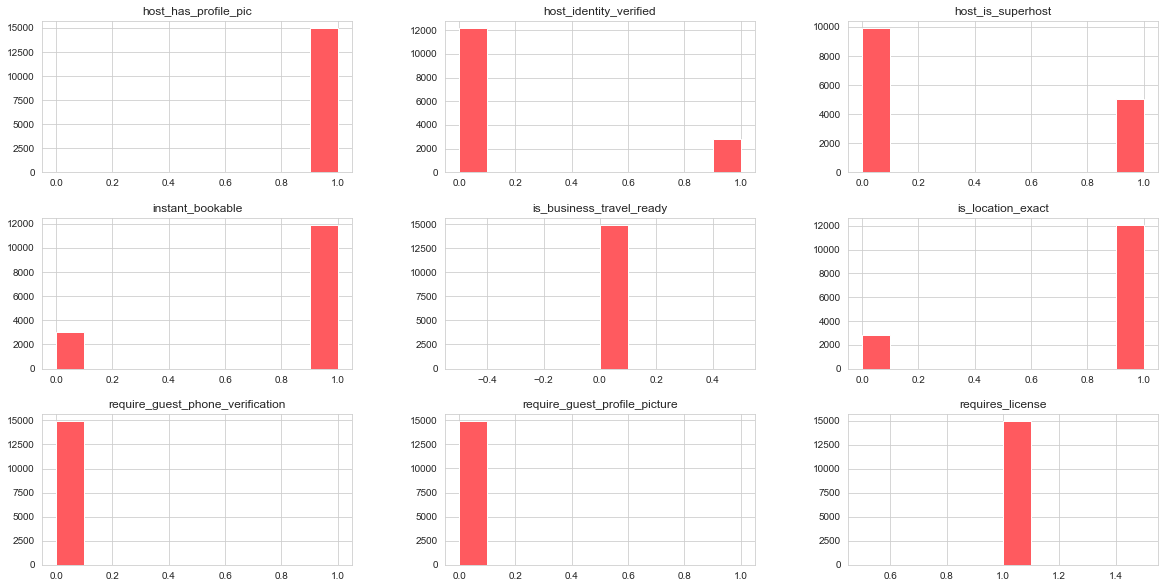

In [51]:
# Columns with only booleans for Verfication Purposes:
listing[['host_is_superhost',
         'host_has_profile_pic', 
         'host_identity_verified', 
         'require_guest_profile_picture',
         'require_guest_phone_verification',
         'requires_license', 
         'instant_bookable', 
         'is_business_travel_ready', 
         'is_location_exact'
        ]].hist(figsize=(20,10), color='#FF5A5F');

<div class="alert alert-block alert-success">

<b>Observation:</b>

As shown above some of the features showed uniform result. Hence will be dropping them as they will not be affect the price. 
- host_has_profile_pic
- is_business_travel_ready
- require_guest_phone_verification
- require_guest_profile_picture
- requires_license

</div>

In [52]:
listing.drop(['host_has_profile_pic',
              'is_business_travel_ready',
              'require_guest_phone_verification',
              'require_guest_profile_picture',
              'requires_license'], axis=1, inplace=True)

##### c. Minimum and Maximum Nights

<div class="alert alert-block alert-success">

<b>Observation:</b>

There are multiple columns that are related to minimum and maximum night stays. To avoid overlapping of data, I will using the basic two which have not been altered.

</div>

In [53]:
listing.drop(['minimum_minimum_nights',
             'maximum_minimum_nights',
             'minimum_maximum_nights',
             'maximum_maximum_nights',
             'minimum_nights_avg_ntm',
             'maximum_nights_avg_ntm'], axis=1, inplace=True)

##### d. Categorical Columns

##### i. property_type

<div class="alert alert-block alert-success">

<b>Observation:</b>

There are a total of 29 unique property types with a majority being the Apartment. However other property types (e.g. house, condominium, serviced apartment) can be considered to be in the same category as well. 

</div>

<div class="alert alert-block alert-warning">

<b>Note to Self:</b>
to regroup?

</div>

In [75]:
print(listing.property_type.nunique())
listing.property_type.value_counts()

29


Apartment             8801
House                 2543
Hostel                1122
Hotel                  719
Condominium            463
Aparthotel             243
Boutique hotel         227
Villa                  169
Serviced apartment     168
Ryokan (Japan)         166
Hut                     55
Loft                    52
Guesthouse              48
Bed and breakfast       41
Townhouse               38
Guest suite             23
Tiny house              20
Other                   18
Cabin                    9
Dome house               5
Bungalow                 5
Camper/RV                5
Tent                     5
Nature lodge             4
Resort                   3
Cottage                  1
Earth house              1
Dorm                     1
Castle                   1
Name: property_type, dtype: int64

In [ ]:
# # Regroup and rename property type
# listing.property_type.replace({
#     '': '',
#     '': '',
#     '': '',
#     '': '', 
#     '': '', 
#     '': '', 
#     '': '', 
#     '': '', 
#     }, inplace=True)

##### ii. room_type

In [56]:
listing.room_type.value_counts()

Entire home/apt    10275
Private room        3268
Hotel room           724
Shared room          689
Name: room_type, dtype: int64

In [76]:
# Rename room type
listing.room_type.replace({
    'Entire home/apt': 'entire_home_apt',
    'Private room': 'private_room',
    'Hotel room': 'hotel_room',
    'Shared room': 'shared_room',  
    }, inplace=True)

##### iii. bed_type

<div class="alert alert-block alert-success">

<b>Observation:</b>

This column seem kinda redundent since majority are the same bed. Hence will be dropping this column. 

</div>

In [57]:
listing.bed_type.value_counts()

Real Bed         14903
Futon               45
Pull-out Sofa        4
Airbed               3
Couch                1
Name: bed_type, dtype: int64

In [58]:
listing.drop(['bed_type'], axis=1, inplace=True)

##### iv. amenities

<div class="alert alert-block alert-success">

Amenities is a list of additional features in the property where i believe people look at before (e.g. if there is wifi), committing the booking. However not all amenities are of the same importance.

</div>

In [59]:
listing.amenities.head()

0    {TV,Internet,Wifi,Kitchen,"Paid parking off pr...
1    {TV,Internet,Wifi,"Air conditioning",Kitchen,"...
2    {TV,Wifi,"Air conditioning",Kitchen,"Hot tub",...
3    {TV,Internet,Wifi,"Air conditioning",Kitchen,"...
4    {TV,Internet,Wifi,"Air conditioning",Kitchen,"...
Name: amenities, dtype: object

In [60]:
listing.amenities[:1]

0    {TV,Internet,Wifi,Kitchen,"Paid parking off pr...
Name: amenities, dtype: object

In [61]:
listing['amenities'] = listing['amenities'].str.replace('{', '').str.replace('}','').str.replace('"', '')
listing['amenities'] = listing['amenities'].str.lower()

all_amenities_count = pd.array(listing.amenities.str.split(',').sum()).value_counts()
all_amenities_count.head(50)

air conditioning              14813
hair dryer                    14744
essentials                    14473
shampoo                       14470
smoke alarm                   13768
wifi                          13606
hangers                       12732
washer                        12689
heating                       12332
fire extinguisher             12108
kitchen                       12055
hot water                     11490
refrigerator                  10678
tv                            10663
laptop-friendly workspace     10338
microwave                      9990
dishes and silverware          9212
carbon monoxide alarm          9194
iron                           9057
private entrance               8322
stove                          7670
long term stays allowed        7294
bed linens                     7065
cooking basics                 6152
self check-in                  5755
elevator                       5158
lock on bedroom door           5036
dryer                       

In [62]:
all_amenities_count.tail(50)

doorman                       41
bread maker                   33
barbecue utensils             31
roll-in shower                30
full kitchen                  29
fixed grab bars for toilet    29
bathtub with bath chair       25
lake access                   23
pool                          22
baking sheet                  21
shower chair                  19
disabled parking spot         19
beach essentials              16
other pet(s)                  13
bath towel                    11
fireplace guards              11
roll-in shower with chair      9
beachfront                     8
body soap                      6
toilet paper                   6
bathroom essentials            6
bedroom comforts               6
private bathroom               5
slippers                       5
baby monitor                   5
breakfast table                3
kitchenette                    3
firm mattress                  3
ground floor access            3
                               3
terrace   

<div class="alert alert-block alert-warning">

To select?!

</div>

##### v. Calendar_updated

<div class="alert alert-block alert-success">

<b>Observation:</b>

This column seem kinda redundent since majority are the same bed. Hence will be dropping this column. 

</div>

In [63]:
print("Total categories:", listing.calendar_updated.nunique())
print('')
print("Top 5 categories:")
listing.calendar_updated.value_counts()[:5]

Total categories: 43

Top 5 categories:


today           3180
2 months ago    1867
3 months ago    1575
yesterday        990
2 weeks ago      904
Name: calendar_updated, dtype: int64

In [64]:
print(listing.shape)
listing.head(3).T

(14956, 44)


,0,1,2
id,35303,197677,289597
host_id,151977,964081,341577
host_since,2010-06-25 00:00:00,2011-08-13 00:00:00,2011-01-10 00:00:00
host_response_time,unknown,within a few hours,within a few hours
host_response_rate,unknown,100,100
host_acceptance_rate,unknown,86,82
host_is_superhost,0,1,0
host_listings_count,3,1,2
host_identity_verified,1,1,1
neighbourhood_cleansed,Shibuya Ku,Sumida Ku,Nerima Ku


##### vi. Availability

In [65]:
print("Avail 30days categories:", listing.availability_30.nunique())
print("Avail 60days categories:", listing.availability_60.nunique())
print("Avail 90days categories:", listing.availability_90.nunique())
print("Avail 365days categories:", listing.availability_365.nunique())
print('')
print("Top 5 categories of 30days:")
listing.availability_30.value_counts()[:5]

Avail 30days categories: 31
Avail 60days categories: 61
Avail 90days categories: 91
Avail 365days categories: 366

Top 5 categories of 30days:


0     4263
30    4102
29    2055
28     936
1      447
Name: availability_30, dtype: int64

##### Save DataFrame

In [ ]:
# listing.to_csv("../datasets/listing_cleaned.csv")

##### Merge Dataframe

In [ ]:
# listing_cal = pd.merge(listing, calendar, how='left', on=['id', date','price'])

###  <span style='background:yellow'> 3.3. Neighbourhood </span>

In [66]:
neighbourhood = neighbourhood.drop(['neighbourhood_group'], axis=1)
neighbourhood

,neighbourhood
0,Adachi Ku
1,Akiruno Shi
2,Akishima Shi
3,Aogashima Mura
4,Arakawa Ku
...,...
57,Tachikawa Shi
58,Taito Ku
59,Tama Shi
60,Toshima Ku


<div class="alert alert-block alert-success">

<b>Observation:</b>
Since listing dataframe has the column on neighbourhood_cleansed and country code. This dataframe might not be required. 

</div>

##### Save DataFrame

In [67]:
neighbourhood.to_csv("../datasets/neighbourhood_cleaned.csv")

### <span style='background:yellow'> 3.4 Reviews </span>

In [68]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,35303,810980,2011-12-28,1502908,Firuz,Miyuki's has been a great host. Helpful and ve...
1,35303,2467161,2012-10-01,350719,Jordan,Nice apartment in one of the best areas of Tok...
2,35303,3572628,2013-02-18,4917704,Aymeric,A very nice host and place. The location is in...
3,35303,3952097,2013-03-30,3243253,Blandine,Miyuki is the most smily face I met when I lan...
4,35303,4377509,2013-05-01,1536097,Kayleigh,The location's wonderful. It's close to Haraju...


In [70]:
# Parse date-time string to datetime object
reviews.date = pd.to_datetime(reviews['date'])

In [73]:
# Drop Unneccessary Columns
reviews.drop(['id','reviewer_id','reviewer_name'], axis=1, inplace=True)

<div class="alert alert-block alert-success">

<b>Observation:</b>

In the comments column, there are languages other than english. RNN(?) 

</div>

##### Merge Dataframe

In [ ]:
# final = pd.merge(listing_cal, reviews, how='left', on=['listing_id'])

##### Save DataFrame

In [ ]:
# reviews.to_csv("../datasets/reviews_cleaned.csv")

### <span style='background:yellow'> 4. Full Exploratory Analysis </span>

In [ ]:
listing.price.describe()

In [ ]:
plt.figure(figsize =(12,6))
sns.distplot(listing['price'], kde= True, bins=300, norm_hist = False, color ='#FF5A5F')
plt.tight_layout()
plt.title('Distribution of Listing Price', fontsize = 20);

In [ ]:
listing.room_type.value_counts()

In [ ]:
room_type_count = listing.room_type.value_counts()

# Customise plot color
colors = ['#FF5A5F', '#00A699', '#FC642D']
sns.set_palette(sns.color_palette(colors)

# Plot                
sns.catplot(x="property_type", y="room_type_count", hue="room_type", kind="bar", data=listing);

In [ ]:
fig = plt.figure(figsize=(11,9))
mask = np.triu(np.ones_like(listing.corr()))

# Customise plot color
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(listing.corr(), 
                 annot=False, 
                 annot_kws={'size':10}, 
                 mask=mask,
                 cmap=cmap)

ax.set_title('Collinearity between Features', fontsize=20)
y_min, y_max = ax.get_ylim() 
x_min, x_max = ax.get_xlim()
ax.set_ylim(top=y_max+1) 
ax.set_xlim(right=x_max-1);

<div class="alert alert-block alert-warning">

<b>EDA PLOTS:</b> 

1. Distribution of Review scores 

2. Distribution of listings based on neighbourhood in Tokyo
    - total number of listing (y-axis)
    - neighbourhood in Tokyo (x-axis)
    
3. Popularity of room types in property types

4. see if there is any trend on bookings? (seasonality)

5. listings per host

6. property, room type on price
    

</div>

### <span style='background:yellow'> 5. Feature Engineering </span>

<div class="alert alert-block alert-warning">

<b> Feature Engineering:</b>
- property_type
- room_type
- bed_type
- cancellation_policy
- neighbourhood_group_cleansed
- host_response_time

</div>